In [6]:
!ls

autoencoder.ipynb  motor_data  randomforest.ipynb  SVM.ipynb  Untitled	untitled0.py  XGBoost.ipynb


In [5]:
%cd drive/MyDrive/기계학습론/project

/content/drive/MyDrive/기계학습론/project


In [14]:
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report
import matplotlib.pyplot as plt

In [8]:
# 레이블 생성 함수
def label_func(file):
    if 'abnormal' in file:
        return 1
    else:
        return 0

# 데이터 전처리 함수
def data_preprocessing(normal_dir, abnormal_dir, start_folder, end_folder):
    data = []
    labels = []
    for folder in os.listdir(normal_dir):
        if folder.isdigit():
            folder_number = int(folder)
            if start_folder <= folder_number <= end_folder:
                time_vib_path = os.path.join(normal_dir, folder, "time_vib")
                if os.path.exists(time_vib_path):
                    for file in os.listdir(time_vib_path):
                        process_file(time_vib_path, file, 0, data, labels)

    for folder in os.listdir(abnormal_dir):
        if folder.isdigit():
            folder_number = int(folder)
            if start_folder <= folder_number <= end_folder:
                time_vib_path = os.path.join(abnormal_dir, folder, "time_vib")
                if os.path.exists(time_vib_path):
                    for file in os.listdir(time_vib_path):
                        process_file(time_vib_path, file, 1, data, labels)

    return np.array(data), np.array(labels)

# 파일 처리 함수
def process_file(path, file, label, data, labels):
    file_path = os.path.join(path, file)
    try:
        df = pd.read_csv(file_path)
        time_data = df.iloc[:, 0].values  # 첫 번째 열은 시간
        amplitude_data = df.iloc[:, 1].values  # 두 번째 열은 진폭
        step_size = 128  # 50% 중복을 위한 스텝 크기

        # 시간 간격 계산
        dt = np.mean(np.diff(time_data))

        for i in range(0, len(amplitude_data) - 256 + 1, step_size):
            segment = amplitude_data[i:i+256]

            # 수치 미분을 사용하여 속도 및 가속도 계산
            velocity = np.diff(segment) / dt
            acceleration = np.diff(velocity) / dt

            # 패딩 추가
            acceleration_padded = np.pad(acceleration, (1, 1), 'constant', constant_values=(0, 0))

            # 데이터를 리스트에 추가
            data.append(acceleration_padded)
            labels.append(label)
    except Exception as e:
        print(f"파일 처리 중 오류 발생: {file_path}, 오류: {e}")


# 데이터 경로 설정
normal_dir_train = 'motor_data/normal'
abnormal_dir_train = 'motor_data/abnormal'
normal_dir_test = 'motor_data/normal'
abnormal_dir_test = 'motor_data/abnormal'

# 데이터 처리
data_train, labels_train = data_preprocessing(normal_dir_train, abnormal_dir_train, 1, 15)
data_test, labels_test = data_preprocessing(normal_dir_test, abnormal_dir_test, 16, 20)

In [11]:

# 데이터를 2D로 변환
X_train = np.array(data_train).reshape(len(data_train), -1)
y_train = np.array(labels_train)

X_test = np.array(data_test).reshape(len(data_test), -1)
y_test = np.array(labels_test)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM 모델 선언 및 학습
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)



SVC(probability=True, random_state=42)

In [12]:
# 예측
y_pred = svm_model.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 1.0



=== Train Performance ===
Train Accuracy: 0.9999465983125067


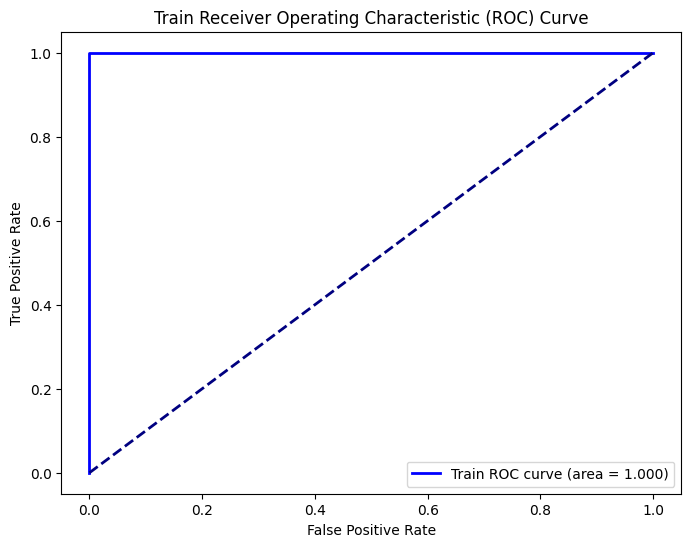

Train ROC AUC SCORE: 1.0

Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9348
           1       1.00      1.00      1.00      9378

    accuracy                           1.00     18726
   macro avg       1.00      1.00      1.00     18726
weighted avg       1.00      1.00      1.00     18726


=== Test Performance ===
Test Accuracy: 1.0


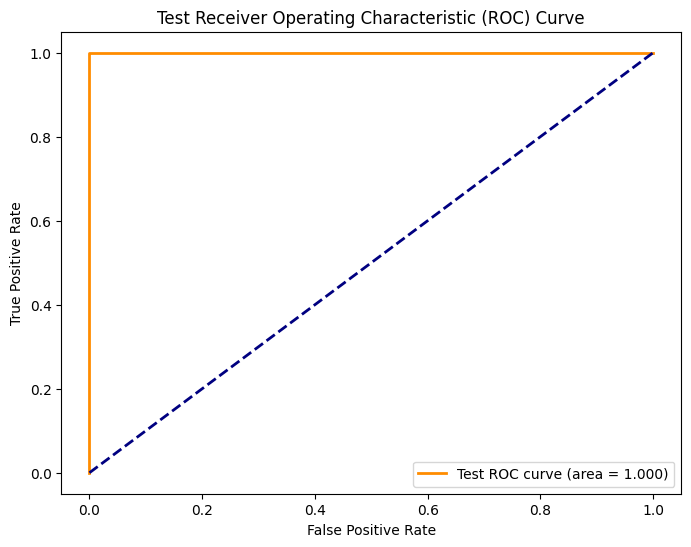

Test ROC AUC SCORE: 1.0

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3114
           1       1.00      1.00      1.00      3114

    accuracy                           1.00      6228
   macro avg       1.00      1.00      1.00      6228
weighted avg       1.00      1.00      1.00      6228



In [15]:

# Train 데이터 성능 평가
print("\n=== Train Performance ===")
y_train_pred = svm_model.predict(X_train)

# Train 데이터 정확도
train_accuracy = accuracy_score(y_train, y_train_pred)
print('Train Accuracy:', train_accuracy)

# Train 데이터 ROC AUC 계산
y_train_proba = svm_model.predict_proba(X_train)[:, 1]
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_proba)
train_roc_auc = auc(train_fpr, train_tpr)

# Train ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label='Train ROC curve (area = {:.3f})'.format(train_roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Train ROC AUC SCORE:', train_roc_auc)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred))

# Test 데이터 성능 평가
print("\n=== Test Performance ===")
y_test_pred = svm_model.predict(X_test)

# Test 데이터 정확도
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test Accuracy:', test_accuracy)

# Test 데이터 ROC AUC 계산
y_test_proba = svm_model.predict_proba(X_test)[:, 1]
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)
test_roc_auc = auc(test_fpr, test_tpr)

# Test ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label='Test ROC curve (area = {:.3f})'.format(test_roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('Test ROC AUC SCORE:', test_roc_auc)
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
